In [1]:
import torch
import matplotlib.pyplot as plt
import deepxde as dde
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [ ]:
# define PDE, boundary conditions and loading

# x ~ input: x[:,0] - spatial coordinates, 1D, subsequently referred to as x in comments
#            x[:,1] - temporal coordinates, 1D, , subsequently referred to as t in comments
# 
# y ~ output: y[:,0] ~ w, displacement            

def d_xx(x, y):

    # compute dw/dx^2 and dw/dt^2

    return dde.grad.hessian(y, x)


def d_xxx(x, y):

    # compute third derivate of x w.r.t. to x and t

    return dde.grad.jacobian(d_xx(x, y), x)

def pde(x, y):

    # dw/dx^4 + dw/dt^2 - p(x,t) = 0

    dy_xx = dde.grad.hessian(y, x, j=0, i=0)
    dy_xxxx = dde.grad.hessian(dy_xx, x, j=0, i=0) 
    d_tt = dde.grad.hessian(y, x, i=1, j=1)

    return dy_xxxx + d_tt - p(x)

# loading

def p(x):

    x_t = x[:,1:2]
    x_s = x[:,0:1]

    #return -torch.matmul(torch.ones(x_s.size(dim=0),1),torch.transpose(torch.cos(torch.pi*x_t),0,1)) 

    return (1-16*torch.pi**2)*torch.sin(x_s)*torch.cos(x_t*4*torch.pi)

In [4]:
# define domain

l_spatial = 0
r_spatial = torch.pi
l_time = 0
r_time = 1

L = 1

geom = dde.geometry.Interval(l_spatial,r_spatial)
timedomain = dde.geometry.TimeDomain(l_time,r_time)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


In [5]:
# boundary conditions

def boundary_l_space(x, on_boundary):
    return on_boundary and np.isclose(x[0], l_spatial)


def boundary_r_space(x, on_boundary):
    return on_boundary and np.isclose(x[0], r_spatial)
    

bc1 = dde.DirichletBC(geomtime, lambda x: 0, boundary_l_space)
bc2 = dde.OperatorBC(geomtime, lambda x, y, _: dde.grad.hessian(y, x, i=0, j=0), boundary_l_space)
bc3 = dde.DirichletBC(geomtime, lambda x: 0, boundary_r_space)
bc4 = dde.OperatorBC(geomtime, lambda x, y, _: dde.grad.hessian(y, x, i=0, j=0), boundary_r_space)

# initial conditions

def func(x):

    return torch.sin(torch.from_numpy(x[:,0:1])).to(device)

ic1 = dde.IC(geomtime, func , lambda _, on_initial: on_initial) #torch.sin(torch.pi*torch.from_numpy(x[:,0:1]).to(device))
ic2 = dde.OperatorBC( geomtime, lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1), lambda _, on_initial: on_initial )


In [8]:
# analytical solution - taken from https://doi.org/10.1109/TNNLS.2023.3310585

def sol(x):

    return torch.sin(torch.from_numpy(x[:,0:1]))*torch.cos(torch.from_numpy(x[:,1:2])*4*torch.pi)


In [22]:
# create problem dataset & define model 
dde.config.set_default_float("float64")

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc1, bc2, bc3, bc4, ic1, ic2],
    num_domain=2000,
    num_boundary=100,
    num_initial=100,
    solution=sol,
    num_test=1000,
)

layer_size = [2] + [50] * 10 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

lw = [10, 1, 1, 1, 1, 10, 1]

model = dde.Model(data, net)
model.compile("adam", lr=0.0001, loss_weights=lw, metrics=["l2 relative error"])

model.train(epochs=5000, display_every=100)

model.compile("L-BFGS", loss_weights=lw)

losshistory, train_state = model.train(iterations=10000, display_every=500)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

dde.utils.external.save_best_state(train_state, 'best_train_state.dat', 'best_test_state.dat')

Set the default float type to float64
Compiling model...
'compile' took 0.000358 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric   
0         [6.16e+04, 6.70e-03, 1.19e-03, 2.63e-03, 3.02e-05, 4.23e+00, 1.20e-02]    [6.26e+04, 6.70e-03, 1.19e-03, 2.63e-03, 3.02e-05, 4.23e+00, 1.20e-02]    [9.97e-01]    
100       [4.48e+04, 1.17e+00, 1.15e-02, 8.38e-01, 1.71e-03, 6.13e+01, 1.83e+01]    [5.17e+04, 1.17e+00, 1.15e-02, 8.38e-01, 1.71e-03, 6.13e+01, 1.83e+01]    [2.72e+00]    
200       [4.08e+04, 5.01e-01, 4.95e-02, 8.47e-01, 1.18e-03, 6.23e+01, 1.89e+01]    [4.86e+04, 5.01e-01, 4.95e-02, 8.47e-01, 1.18e-03, 6.23e+01, 1.89e+01]    [2.50e+00]    
300       [2.94e+04, 1.12e+00, 2.71e-01, 1.15e+00, 1.33e-02, 3.82e+00, 1.58e+01]    [3.56e+04, 1.12e+00, 2.71e-01, 1.15e+00, 1.33e-02, 3.82e+00, 1.58e+01]    [2.64e+00]    
400       [2.06e+04, 3.34e+00, 2

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (67,) + inhomogeneous part.

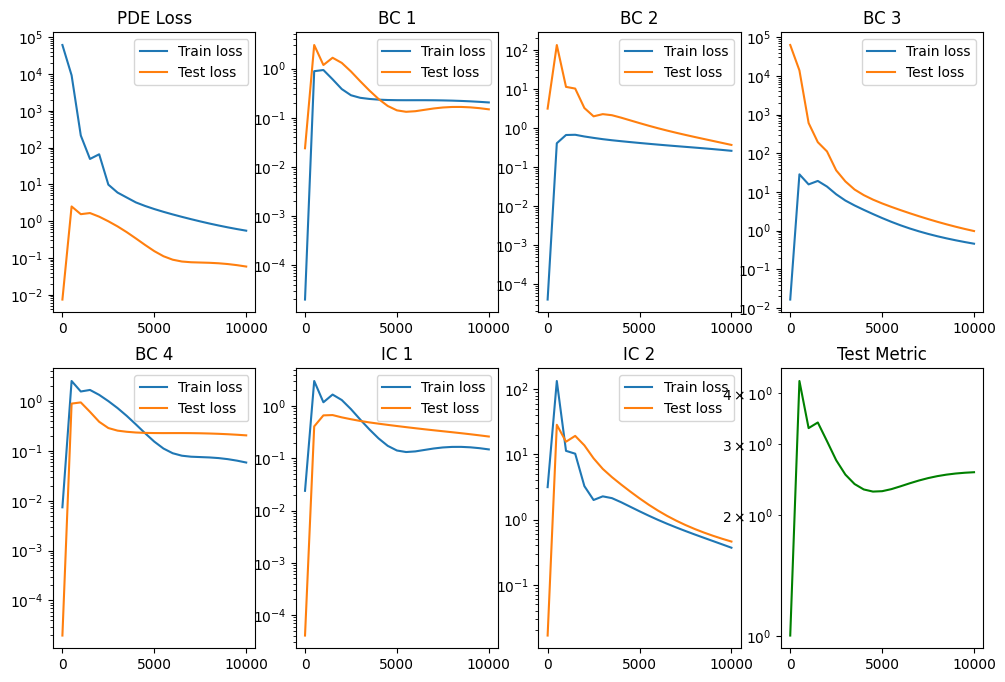

In [23]:
# visualize loss history 

loss_history_nice = np.loadtxt("loss.dat", skiprows=1)

import matplotlib.pyplot as plt

loss_counter = 1
labels = ["PDE Loss", "BC 1", "BC 2", "BC 3", "BC 4", "IC 1", "IC 2", "Test Metric"]

fig, ax = plt.subplots(2,4, figsize=(12,8))

for i in range(2):

    for j in range(4):
        
        if i != 1 or j!=3:       

            ax[i,j].semilogy(loss_history_nice[:,0],loss_history_nice[:,loss_counter], label='Train loss')
            ax[i,j].semilogy(loss_history_nice[:,0],loss_history_nice[:,loss_counter+1], label='Test loss')
            ax[i,j].legend()
            ax[i,j].set_title(labels[i*4+j])

            loss_counter = loss_counter+2

        else: 
            ax[i,j].semilogy(loss_history_nice[:,0],loss_history_nice[:,loss_counter], label='Test Metric', color='green')
            ax[i,j].set_title(labels[i*4+j])

Text(0.5, 0.92, 'Best training state')

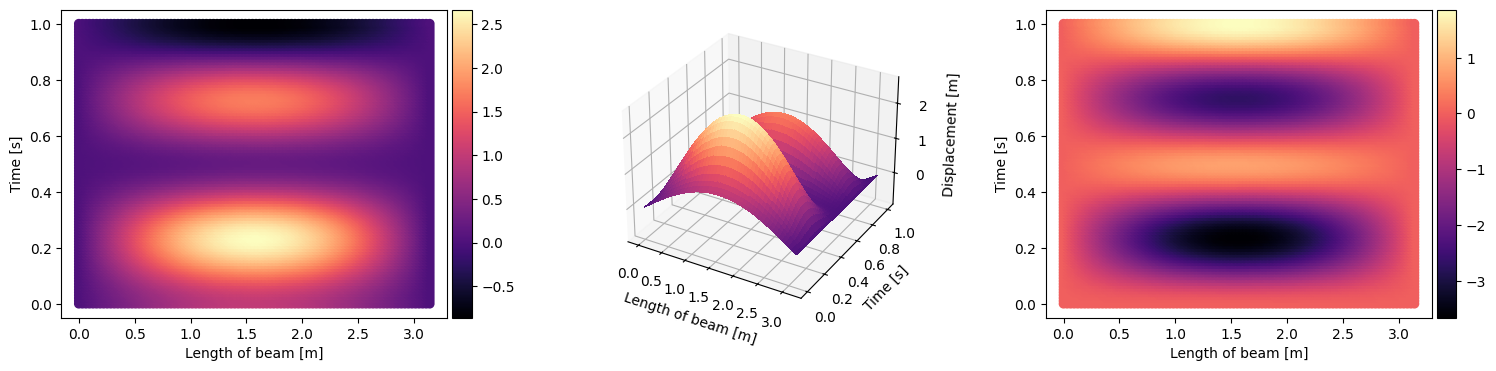

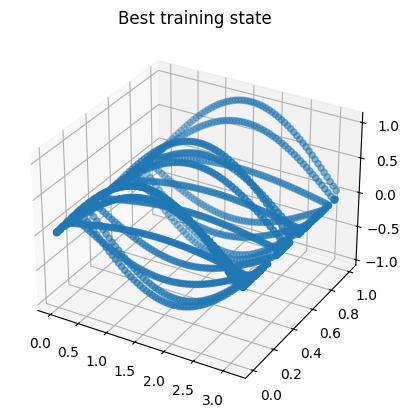

In [24]:
#%matplotlib qt

# ----------------------------------------------------------------
# Evaluate the model

# Define some query points on our compuational domain.
# Number of points in each dimension:
x_dim, t_dim = (100, 100)

# Bounds of 'x' and 't':
x_min, t_min = (l_spatial, l_time)
x_max, t_max = (r_spatial, r_time)

# Create tensors:
t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)

xx, tt = np.meshgrid(x, t)
X = np.vstack((np.ravel(xx), np.ravel(tt))).T

# Compute the model prediction.
y_pred = model.predict(X) 

# compute the true model solution
Y = sol(X).numpy()


# -----------------------------------------------------------------
# Visualize the results

fig = plt.figure(figsize=[18,4]) #figsize=plt.figaspect(0.5)

# scatterplot view from above
ax = fig.add_subplot(1, 3, 1)
scat = ax.scatter(X[:,0], X[:,1], c=y_pred, cmap=cm.magma)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(scat, cax=cax, orientation='vertical')

ax.set_xlabel("Length of beam [m]")
ax.set_ylabel("Time [s]")

# 3d view of how beam deformation evaluates
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot_surface(xx,tt,y_pred.reshape(t_dim, x_dim),cmap=cm.magma,linewidth=0,antialiased=False)
ax.set_xlabel("Length of beam [m]")
ax.set_ylabel("Time [s]")
ax.set_zlabel("Displacement [m]")

# imshow picute from above, same as first
ax = fig.add_subplot(1, 3, 3)
#im = ax.imshow(y_pred.reshape(t_dim, x_dim), cmap=cm.magma, origin='lower')
im = ax.scatter(X[:,0], X[:,1], c=(Y-y_pred), cmap=cm.magma)
ax.set_xlabel("Length of beam [m]")
ax.set_ylabel("Time [s]")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


# additional plot of best training state
best_y_test = np.loadtxt("best_test_state.dat")
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(best_y_test[:,0], best_y_test[:,1], best_y_test[:,2])
ax.set_title("Best training state")



### 2.) Mixed formulation PINN using one NN with three outputs

In [9]:
def pde_new(x, y):

    # dw/dx^4 + dw/dt^2 - p(x,t) = 0
    
    dy_xxxx = dde.grad.hessian(y[:,1:2], x, i=0, j=0)
    dy_tt = dde.grad.hessian(y[:,0:1], x, i=1, j=1)
    dy_xx = dde.grad.hessian(y[:,0:1], x, i=0, j= 0)
   
    return dy_xxxx + dy_tt - p(x) + dy_xx - y[:,1:2] + dy_tt - y[:,2:3]

bc5 = dde.DirichletBC(geomtime, lambda x, y: y[0,0:1], boundary_l_space)
bc6 = dde.DirichletBC(geomtime, lambda x, y: y[0,1:2], boundary_l_space)
bc7 = dde.DirichletBC(geomtime, lambda x, y: y[-1,0:1], boundary_r_space)
bc8 = dde.DirichletBC(geomtime, lambda x, y: y[-1,1:2], boundary_r_space)

# initial conditions

#ic1 = dde.IC(geomtime, lambda x: 0 , lambda _, on_initial: on_initial) #torch.sin(torch.pi*torch.from_numpy(x[:,0:1]).to(device))
#ic2 = dde.OperatorBC(
#        geomtime,
#        lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1),
#         lambda _, on_initial: on_initial
#    )

Set the default float type to float64
Compiling model...
'compile' took 0.000310 s



Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [5.39e+02, 1.62e-02, 6.20e-03, 1.32e-01, 2.61e-02, 3.48e-01, 4.92e-02]    [5.49e+02, 1.62e-02, 6.20e-03, 1.32e-01, 2.61e-02, 3.48e-01, 4.92e-02]    []  
100       [5.25e+02, 7.59e-03, 1.10e-03, 7.13e-02, 1.24e-02, 3.82e-01, 2.22e-02]    [5.32e+02, 7.59e-03, 1.10e-03, 7.13e-02, 1.24e-02, 3.82e-01, 2.22e-02]    []  
200       [5.24e+02, 1.07e-02, 9.16e-04, 5.64e-02, 5.39e-03, 3.81e-01, 1.77e-02]    [5.32e+02, 1.07e-02, 9.16e-04, 5.64e-02, 5.39e-03, 3.81e-01, 1.77e-02]    []  
300       [5.24e+02, 1.36e-02, 7.86e-04, 5.08e-02, 2.66e-03, 3.72e-01, 1.35e-02]    [5.32e+02, 1.36e-02, 7.86e-04, 5.08e-02, 2.66e-03, 3.72e-01, 1.35e-02]    []  
400       [5.24e+02, 1.61e-02, 7.11e-04, 5.15e-02, 1.76e-03, 3.56e-01, 9.71e-03]    [5.32e+02, 1.61e-02, 7.11e-04, 5.15e-02, 1.76e-03, 3.56e-01, 9.71e-03]    [

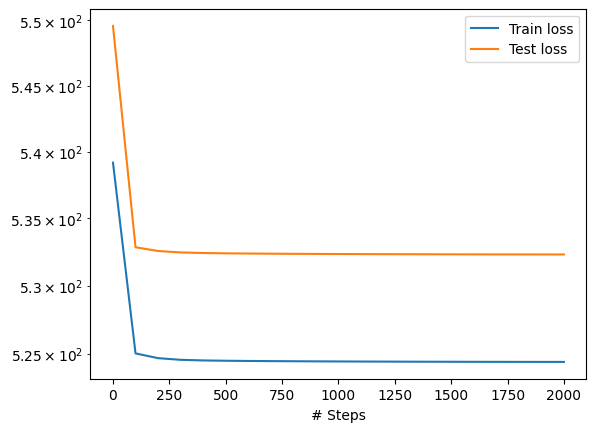

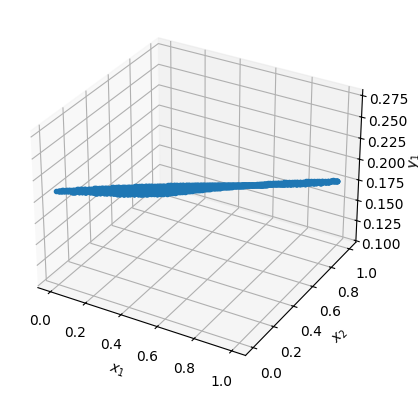

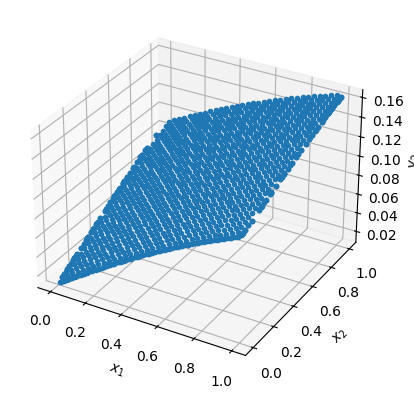

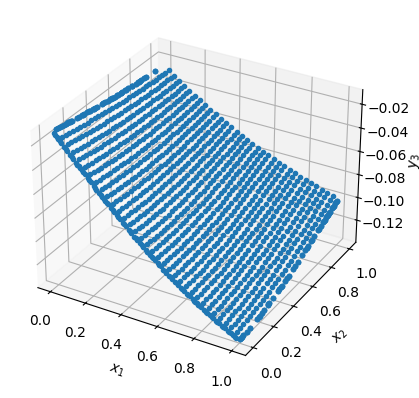

In [10]:
# create problem dataset & define model 
dde.config.set_default_float("float64")

data_new = dde.data.TimePDE(
    geomtime,
    pde_new,
    [bc1, bc2, bc3, bc4, ic1, ic2],
    num_domain=3000,
    num_boundary=100,
    num_initial=100,
    #solution=sol,
    num_test=1000,
)

layer_size = [2] + [20] * 5 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net_new = dde.maps.FNN(layer_size, activation, initializer)

lw = [1000, 1, 1, 1, 1, 1, 1]

model_new = dde.Model(data_new, net_new)
model_new.compile("adam", lr=0.0001, loss_weights=lw)

#model_new.train(epochs=4000, display_every=100)
#model_new.compile("L-BFGS", loss_weights=lw)

losshistory, train_state = model_new.train(epochs=2000, display_every=100)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

### 3.) Mixed-formulation PINN with one NN for each output

In [12]:
# create problem dataset & define model 
dde.config.set_default_float("float64")

data_new = dde.data.TimePDE(
    geomtime,
    pde_new,
    [bc1, bc2, bc3, bc4, ic1, ic2],
    num_domain=3000,
    num_boundary=100,
    num_initial=100,
    #solution=sol,
    num_test=1000,
)

layer_size = [2, [20, 20, 20], [20, 20, 20], [20, 20, 20], 3]
activation = "tanh"
initializer = "Glorot uniform"
net_new = dde.maps.PFNN(layer_size, activation, initializer)

lw = [1000, 1, 1, 1, 1, 1, 1]

model_new = dde.Model(data_new, net_new)
model_new.compile("adam", lr=0.0005, loss_weights=lw)

#model_new.train(epochs=4000, display_every=100)
#model_new.compile("L-BFGS", loss_weights=lw)

losshistory, train_state = model_new.train(epochs=5000, display_every=100)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Set the default float type to float64
Compiling model...
'compile' took 0.000362 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.52e+03, 4.91e-02, 3.99e-03, 2.98e-01, 1.46e-01, 8.60e-01, 1.07e-01]    [1.59e+03, 4.91e-02, 3.99e-03, 2.98e-01, 1.46e-01, 8.60e-01, 1.07e-01]    []  
100       [5.26e+02, 7.93e-03, 2.25e-03, 6.77e-02, 1.04e-01, 6.63e-01, 8.31e-04]    [5.34e+02, 7.93e-03, 2.25e-03, 6.77e-02, 1.04e-01, 6.63e-01, 8.31e-04]    []  
200       [5.25e+02, 2.15e-02, 2.10e-03, 3.03e-02, 8.82e-02, 5.69e-01, 7.95e-04]    [5.33e+02, 2.15e-02, 2.10e-03, 3.03e-02, 8.82e-02, 5.69e-01, 7.95e-04]    []  
300       [5.25e+02, 3.89e-02, 1.77e-03, 8.86e-03, 7.41e-02, 4.87e-01, 1.11e-03]    [5.33e+02, 3.89e-02, 1.77e-03, 8.86e-03, 7.41e-02, 4.87e-01, 1.11e-03]    []  
400       [5.24e+02, 5.65e-02, 1.45e-03, 7.15e-04, 6.27e-02, 4.23e-01, 1.36

KeyboardInterrupt: 